In [2]:
%matplotlib inline


# PCEN Streaming

This notebook demonstrates how to use streaming IO with `librosa.pcen`
to do dynamic per-channel energy normalization on a spectrogram incrementally.

This is useful when processing long audio files that are too large to load all at
once, or when streaming data from a recording device.


We'll need numpy and matplotlib for this example



In [1]:
import numpy as np
import matplotlib.pyplot as plt

import soundfile as sf

import librosa as librosa
import librosa.display as display

First, we'll start with an audio file that we want to stream



In [3]:
filename = 'Khoparzi-Audio.wav'

Next, we'll set up the block reader to work on short segments of
audio at a time.



In [5]:
# We'll generate 64 frames at a time, each frame having 2048 samples
# and 75% overlap.
#

n_fft = 2048
hop_length = 512

# fill_value pads out the last frame with zeros so that we have a
# full frame at the end of the signal, even if the signal doesn't
# divide evenly into full frames.
sr = librosa.get_samplerate(filename)

stream = librosa.stream(filename, block_length=16,
                        frame_length=n_fft,
                        hop_length=hop_length,
                        mono=True,
                        fill_value=0)

For this example, we'll compute PCEN on each block, find the maximum
response over frequency, and store the results in a list.



In [7]:
# Make an array to store the frequency-averaged PCEN values
pcen_blocks = []

# Initialize the PCEN filter delays to steady state
zi = None

for y_block in stream:
    # Compute the STFT (without padding, so center=False)
    D = librosa.stft(y_block, n_fft=n_fft, hop_length=hop_length,
                     center=False)

    # Compute PCEN on the magnitude spectrum, using initial delays
    # returned from our previous call (if any)
    # store the final delays for use as zi in the next iteration
    P, zi = librosa.pcen(np.abs(D), sr=sr, hop_length=hop_length,
                         zi=zi, return_zf=True)

    # Compute the max PCEN over frequency, and append it to our list
    pcen_blocks.extend(np.max(P, axis=0))

# Cast to a numpy array for use downstream
pcen_blocks = np.asarray(pcen_blocks)

For the sake of comparison, let's see how it would look had we
run PCEN on the entire spectrum without block-wise processing



In [10]:
y, sr = librosa.load(filename, sr=sr)

# Keep the same parameters as before
D = librosa.stft(y, n_fft=n_fft, hop_length=hop_length, center=False)

# Compute pcen on the magnitude spectrum.
# We don't need to worry about initial and final filter delays if
# we're doing everything in one go.
P = librosa.pcen(np.abs(D), sr=sr, hop_length=hop_length)

pcen_full = np.max(P, axis=0)

KeyboardInterrupt: 

In [11]:
hop_length

512

Plot the PCEN spectrum and the resulting magnitudes



<Figure size 576x288 with 0 Axes>

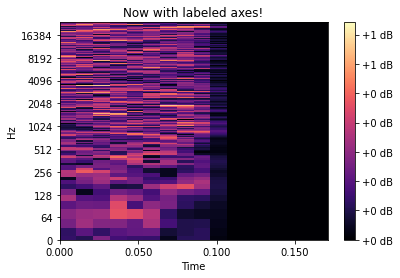

In [12]:
# plot the spectrum
plt.figure(figsize=(8, 4))
fig, ax = plt.subplots()
img = librosa.display.specshow(P, sr=sr, hop_length=hop_length,
                         x_axis='time', y_axis='log', ax=ax)
ax.set(title='Now with labeled axes!')
fig.colorbar(img, ax=ax, format="%+2.f dB")